In [1]:
import pandas as pd
import importlib

import sys 
import os

os.chdir("../Feature_Design")
from author_properties_transformers import author_influence
from word2vec_transformers import conceptcluster, tokenizer
import data_preprocessor
os.chdir("../Regression")

from datetime import timezone, datetime
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier, DummyRegressor
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import FunctionTransformer
import seaborn as sns


# Load and clean data:

In [23]:
def load(subreddit, nrows = None):
    df_messy = pd.read_csv("../Data/subreddit_" + subreddit + "/full.csv", nrows = nrows)

    # This removes weekly threads, and rows that have been deleted. Also removes posts that are not text posts.
    # Creates more granular time features as well.
    df_messy, award_cols = data_preprocessor.preprocess(df_messy)
    
    # TODO: this may be too severe of a cleanup.
    

    # make tokenized columns for the NLP methods
    tokenizer().in_place(X = df_messy, cols = ['title', 'selftext'])

    cols = [  'id',  'author', 'score', 'ups', 'downs', 'gilded', 'upvote_ratio', 'total_awards_received', 'num_comments', 'weektime', 'time_of_day', 'tokenized_title', 'tokenized_selftext'] + award_cols

    df = df_messy[ cols]
    return df, award_cols, df_messy


for subreddit in ["WallStreetBets"]: #, "TraditionalCurses", "WritingPrompts", "TwoSentenceHorror", "Jokes"]:
    #df, award_cols, df_messy = load(subreddit, nrows = None)
    #df.to_csv("../Data/cleaned_" + subreddit + ".csv")

    df = pd.read_csv("../Data/cleaned_" + subreddit + ".csv", nrows = 10000)

In [3]:
award_cols = [col for col in list(df.columns) if col[:6] == "award_"]

## Create feature transformers for author features, time features, and nlp features.
For details on the author and nlp transformers see, ../Feature_Design/author_properties_transformers and ../Feature_Design/word2vec_transformers

Briefly, they do the following:

1. Author influence calculates statistics of an authors upvote history from posts in the train set. 

2. Conceptcluster trains a word2vec model, then clusters the word vectors into concepts, and then counts the number of times each concept appear in the title or the selftext. Various options for the clustering approach are possible.

In [4]:
author_stat_features = FeatureUnion([('aggsum', author_influence(kind = 'sum')), 
                           ('aggmean', author_influence(kind = 'mean')), 
                           ('aggmedian', author_influence(kind = 'median')),
                            ('aggcount', author_influence(kind = 'count')),
                            ('aggupvote_ratio', author_influence(kind = 'beta_shrinkage_upvoteratio', prior = 'empirical_bayes')),
                              #('aggpowerlaw', author_influence(kind = 'power_law')) # slows things down a lot      
                           
                           ])


In [28]:
from sklearn.preprocessing import PolynomialFeatures

time_of_day = make_pipeline( make_column_transformer(
                                (FunctionTransformer(lambda x : x), ["time_of_day"] )), PolynomialFeatures(3) 
                                          )

time_features = make_union(  make_pipeline( make_column_transformer(
                                (FunctionTransformer(lambda x : x), ["time_of_day"] )), PolynomialFeatures(3) 
                                          )
                                                   )            
                        


In [9]:
nlp_features = make_union( conceptcluster(  roughclustersize = 15 , verbose = False) )

In [31]:


all_features = make_union ( author_stat_features, time_features, nlp_features )
#all_features = make_union ( time_features )

# just do time with polynomial (quadratic) regression, subtract a baseline value

## Run a regression experiment:

Trying to predict upvotes using those features. No luck so far. 

Comments: xgboost overfits, linear regression underfits.
 

Dummy classifier score: -0.010 (+/- 0.02)
working on LinearRegression()


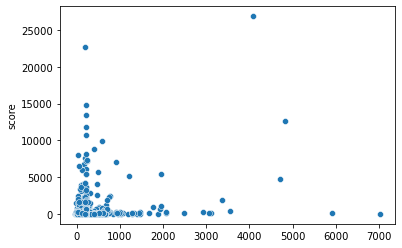

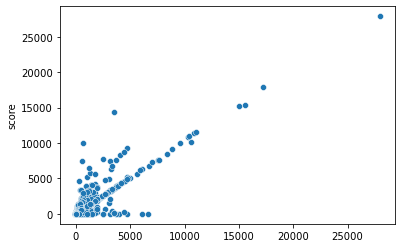

[-0.06155424 -0.25474908 -0.06684971  0.08796038 -0.88781024]


In [32]:

def run_experiment(model, X, y):
    

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)

    
    clf = DummyRegressor()
    scores = cross_val_score(clf, X, y)
    print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
 
    print("working on", model)

    pipe = make_pipeline(all_features, model, verbose = False)
    # all features drops the 'ups' category.
    
    pipe.fit(X_train, y_train, )

    pipe.predict(X_test)

    sns.scatterplot(x = pipe.predict(X_test), y = y_test)
    plt.show()
    sns.scatterplot(x = pipe.predict(X_train), y = y_train)
    plt.show()
    
    score = cross_val_score(pipe, X, y)
    print(score)
    
    return pipe, score


pipes = []
scores = []
for model in [LinearRegression()]: #, xgb.XGBRegressor(random_state=2)]:
    X = df.drop(columns=['total_awards_received', 'num_comments'])
    y = df.score
    pipe, score = run_experiment(model, X, y)
    pipes.append(pipe)
    scores.append(score)

In [30]:
pipe

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('functiontransformer',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000024C188A8E50>),
                                                                   ['time_of_day'])])),
                                 ('polynomialfeatures',
                                  PolynomialFeatures(degree=3))])),
                ('linearregression', LinearRegression())])

In [12]:
#cc = pipes[0]['featureunion'].get_params()['featureunion-3'].get_params()['conceptcluster']
#cc.corpus_df.prediction.value_counts().head(25)
#cc.corpus_df[ cc.corpus_df.prediction == 45]

In [15]:

def run_experiment_classification(model, X, y):
    

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)

    print("working on", model)

    pipe = make_pipeline(all_features, model, verbose = True)
    # all features drops the 'ups' category.
    
    pipe.fit(X_train, y_train)

    pipe.predict(X_test)

    
    clf = DummyClassifier()
    scores = cross_val_score(clf, X, y)
    print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    
    scores = cross_val_score(pipe, X, y)
    print("Model classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    
    return pipe, scores

pipes = []
scores = []
for model in [tree.DecisionTreeClassifier(), LogisticRegression()]: #[LinearRegression(), xgb.XGBRegressor(random_state=2)]:
    X = df.drop(columns=['total_awards_received', 'num_comments'] + award_cols)
    y = df["award_Silver"] > 0 
    pipe, score = run_experiment_classification(model, X, y)
    pipes.append(pipe)
    scores.append(score)

working on DecisionTreeClassifier()
[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  24.7s
[Pipeline]  (step 2 of 2) Processing decisiontreeclassifier, total=   0.0s
Dummy classifier score: 0.966 (+/- 0.00)
[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  19.0s
[Pipeline]  (step 2 of 2) Processing decisiontreeclassifier, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  16.9s
[Pipeline]  (step 2 of 2) Processing decisiontreeclassifier, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  18.0s
[Pipeline]  (step 2 of 2) Processing decisiontreeclassifier, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  14.8s
[Pipeline]  (step 2 of 2) Processing decisiontreeclassifier, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  24.1s
[Pipeline]  (step 2 of 2) Processing decisiontreeclassifier, total=   0.0s
Model classifier score: 0.952 (+/- 0.02)
workin

C:\Users\lnajt\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.3s
Dummy classifier score: 0.966 (+/- 0.00)
[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  33.1s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.1s


C:\Users\lnajt\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  31.8s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.1s


C:\Users\lnajt\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  34.6s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.1s


C:\Users\lnajt\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  35.5s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.1s


C:\Users\lnajt\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Pipeline] ...... (step 1 of 2) Processing featureunion, total=  42.6s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.1s


C:\Users\lnajt\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model classifier score: 0.964 (+/- 0.01)


In [ ]:
# TODO: L1 penalty?